# Optimization & Gradient Descent

## Chapter Outline
<hr>

<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-Learning-Objectives" data-toc-modified-id="Chapter-Learning-Objectives-2">Chapter Learning Objectives</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li><li><span><a href="#1.-Optimization" data-toc-modified-id="1.-Optimization-4">1. Optimization</a></span></li><li><span><a href="#2.-Loss-Functions" data-toc-modified-id="2.-Loss-Functions-5">2. Loss Functions</a></span></li><li><span><a href="#3.-Optimizing-Linear-Regression" data-toc-modified-id="3.-Optimizing-Linear-Regression-6">3. Optimizing Linear Regression</a></span></li><li><span><a href="#4.-Gradient-Descent-With-One-Parameter" data-toc-modified-id="4.-Gradient-Descent-With-One-Parameter-7">4. Gradient Descent With One Parameter</a></span></li><li><span><a href="#5.-Gradient-Descent-With-Two-Parameters" data-toc-modified-id="5.-Gradient-Descent-With-Two-Parameters-8">5. Gradient Descent With Two Parameters</a></span></li><li><span><a href="#6.-Other-Optimization-Algorithms" data-toc-modified-id="6.-Other-Optimization-Algorithms-9">6. Other Optimization Algorithms

## Chapter Learning Objectives
<hr>

- Explain the difference between a model, loss function, and optimization algorithm in the context of machine learning.
- Explain how the gradient descent algorithm works.
- Apply gradient descent to linear and logistic regression.
- Use `scipy.optimize.minimize()` to minimize a function.

## Imports
<hr>

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.plotting import *

/home/user/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## 1. Optimization and Machine Learning
<hr>

In data science and computer science, we optimize a lot of stuff. For example, in linear regression we optimize for the intercept and coefficients of our model, in clustering algorithms like k-means we optimize our clusters, in neural networks we optimize the weights in our network (more on that in a later chapter!), etc.

In one sentence, "optimization" simply refers to minimizing/maximizing a function. For example, what value of $x$ minimizes the function $f(x) = (x-2)^2 + 5$? What is the minimum value? Answers: $x=2$, and $f(x)=5$.

If you're reading this, you're likely already familiar with machine learning. You can start to think of machine learning as a three-step process:
1. **Choose your model**: controls the space of possible functions that map $X$ to $y$ (e.g., a linear model can only learn linear functions)
2. **Choose your loss function**: tells us how to compare these various functions (e.g., is $y=5 + 2x_1+3x_2$ a better model than $y=1 + 10x_1-x_2$?)
3. **Choose your optimization algorithm**: finds the minimum of the loss function (e.g., what is the optimum value of $w_0$ and $w_1$ in $y=w_0 + w_1x$?)

In this chapter we'll be taking a look at optimization in detail and a particular optimization algorithm known as gradient descent.

## 2. Loss Functions
<hr>

Loss functions (also often called "objective functions" or "cost functions", although some debate that these are [slightly different things](https://stats.stackexchange.com/questions/179026/objective-function-cost-function-loss-function-are-they-the-same-thing)) are what we use to map the performance of a model to a real number and it's the thing we want to optimize! For example, here's the mean squared error (MSE), which is a common loss function:

$$f(y,\hat{y})=\frac{1}{n}\sum^{n}_{i=1}(\hat{y_i}-y_i)^2$$

Where $y_i$ is the actual response and $\hat{y_i}$ is the predicted response.

Consider a simple linear regression model $\hat{y_i} = w_0 + w_1x_i$, then our loss function is:

$$f(y,x,w)=\frac{1}{n}\sum^{n}_{i=1}((w_0 + w_1x_i)-y_i))^2$$

The optimization problem here is to find the values of $w_0$ and $w_1$ that minimizes the MSE.

## 3. Optimizing Linear Regression
<hr>

I'm going to build up the intuition for optimization in a practical and visual way with the help of our old friend linear regression.

We'll use a dataset of [Pokemon](https://www.pokemon.com/us/) "attack" and "defense" stats to do this, I'm going to start with just 10 observations:

In [10]:
df = (pd.read_csv("data/pokemon.csv", usecols=['name', 'defense', 'attack'], index_col=0)
        .head(10)
        .sort_values(by='defense')
        .reset_index()
     )
x = df['defense']
y = df['attack']
df

name  attack  defense
0    Caterpie      30       35
1  Charmander      52       43
2   Bulbasaur      49       49
3  Charmeleon      64       58
4     Ivysaur      62       63
5    Squirtle      48       65
6   Charizard     104       78
7   Wartortle      63       80
8   Blastoise     103      120
9    Venusaur     100      123

> Throughout this chapter, I'm leveraging plotting scripts I imported from `utils.plotting`. I abstracted the code out of the notebook to avoid cluttering the material here and because how I made these plots is not important - but feel free to check out the source code if you wish!

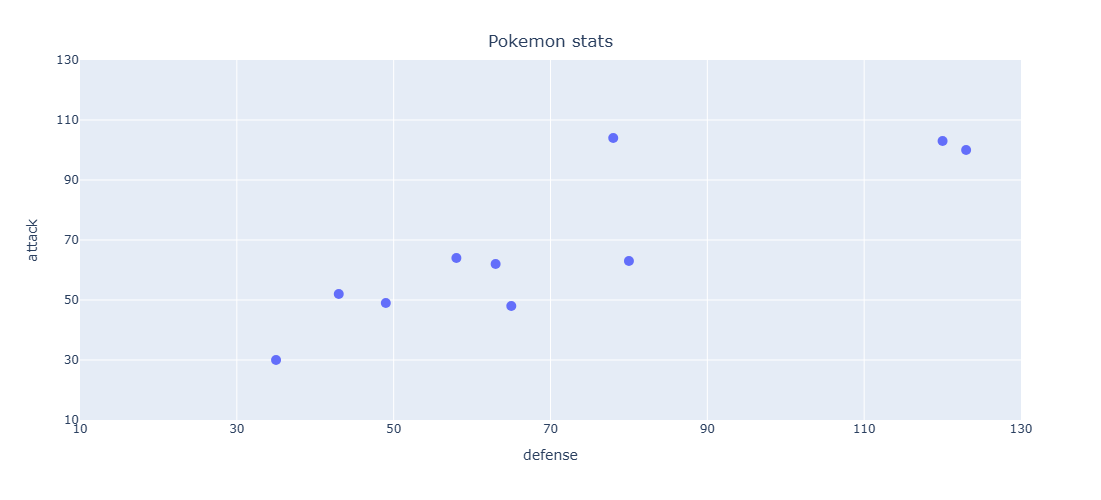

In [12]:
plot_pokemon(x, y)

Recall simple linear regression: $\hat{y_i} = w_0 + w_1x_i$ (where  $w_0$ is the intercept and $w_1$ is the slope coefficient). If we assume ($w_0$, $w_1$) = (10, 0.5) then we would have:

In [14]:
y_hat = 10 + 0.5 * x

Let's plot that result:

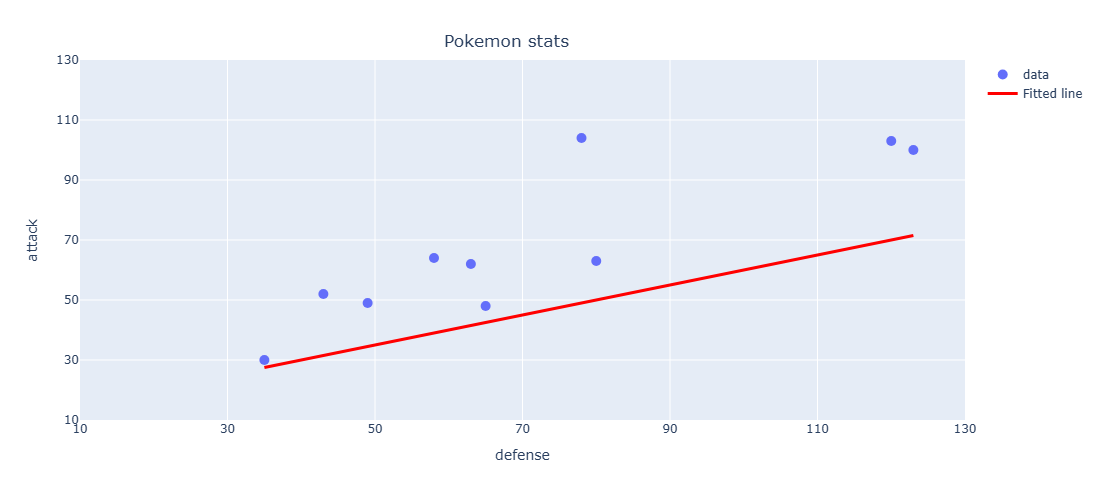

In [18]:
plot_pokemon(x, y, y_hat)

The fit is not very good... We need to optimize it! A **loss function** can help quantify the fit of our model and we want to find the parameters of our model that minimize the loss function. We'll use mean-squared-error (MSE) as our loss function:

$$f(w)=\frac{1}{n}\sum^{n}_{i=1}((w_0 + w_1x_i)-y_i))^2$$

Where $n$ is the number of data points we have (10 in our case). We'll use the sklearn function `mean_squared_error()` which I imported at the top of the notebook to calculate MSE for us:

In [22]:
mean_squared_error(y, y_hat)

680.75

So this is the MSE across all training examples. For now, let's assume the intercept is 0 ($w_0 = 0$) and **just focus on optimizing the slope** ($w_1$). One thing we could do is try many different values for the slope and find the one that minimizes the MSE:

In [25]:
slopes = np.arange(0.4, 1.65, 0.05)
mse = pd.DataFrame({"slope": slopes,
                    "MSE": [mean_squared_error(y, m * x) for m in slopes]})
mse

slope        MSE
0    0.40  1770.0760
1    0.45  1478.6515
2    0.50  1216.7500
3    0.55   984.3715
4    0.60   781.5160
5    0.65   608.1835
6    0.70   464.3740
7    0.75   350.0875
8    0.80   265.3240
9    0.85   210.0835
10   0.90   184.3660
11   0.95   188.1715
12   1.00   221.5000
13   1.05   284.3515
14   1.10   376.7260
15   1.15   498.6235
16   1.20   650.0440
17   1.25   830.9875
18   1.30  1041.4540
19   1.35  1281.4435
20   1.40  1550.9560
21   1.45  1849.9915
22   1.50  2178.5500
23   1.55  2536.6315
24   1.60  2924.2360

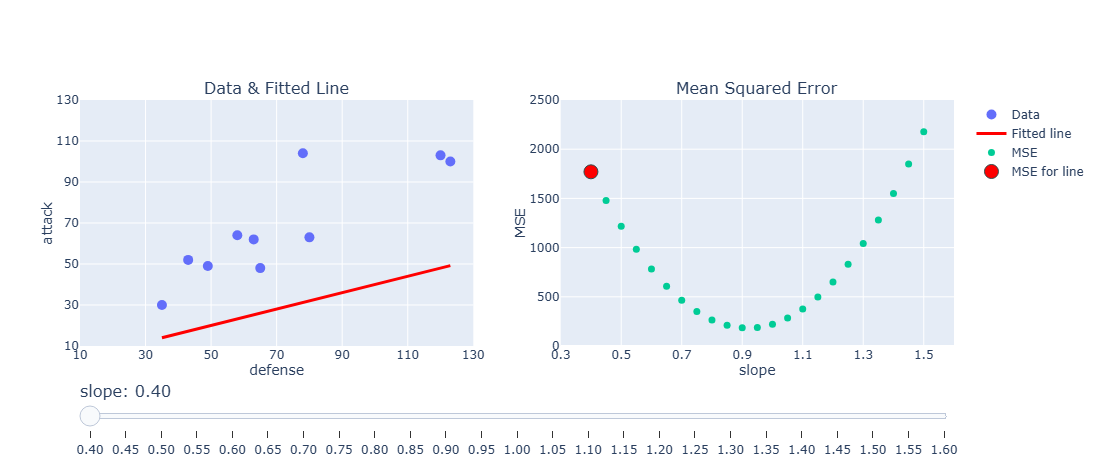

In [29]:
plot_grid_search(x, y, slopes, mean_squared_error)

It looks like a slope of 0.9 gives us the lowest MSE (~184.4). But you can imagine that this "grid search" approach quickly becomes computationally intractable as the size of our data set and number of model parameters increases! So we need a better way to optimize our parameters... we need an optimization algorithm! The one we'll focus on in this chapter is **Gradient Descent**.

## 4. Gradient Descent With One Parameter
<hr>

Gradient descent is an optimization algorithm that can help us optimize our loss function more efficiently than the "manual" approach we tried above. As the name suggest, we are going to leverage the **gradient** of our loss function to help us optimize our model parameters. The gradient is just a vector of (partial) derivatives of the loss function w.r.t the model parameters. Sounds complicated but it's not at all (as I'll hopefully show you).

In plain English, the gradient will tell us two things:
1. Which direction to move our parameter in to decrease loss (i.e., should we increase or decrease its value?)
2. How far to move it (i.e., should we adjust it by 0.1 or 2 or 50 etc.?)

>If you need a refresher on gradients, check out [Appendix A: Gradients Review](appendixA_gradients.ipynb).

Let's forget about the intercept now and just work with this simple linear model: $\hat{y_i}=wx_i$. For this model, the loss function has the form:

$$f(w)=\frac{1}{n}\sum^{n}_{i=1}((wx_i)-y_i))^2$$

The gradient of this function with respect to the parameter $w$ is:

$$\frac{d}{dw}f(w)=\frac{1}{n}\sum^{n}_{i=1}2x_i(wx_i - y_i)$$

Let's code that up and calculate the gradient of our loss function at a slope of $w = 0.5$:

In [54]:
def gradient(x, y, w):
    return 2 * (x * (w * x - y)).mean()

gradient(x, y, w=0.5)

-4942.8

So this is the gradient across all training examples and tells us how to adjust $w$ to reduce the MSE loss over all training examples! Recall from calculus that the **gradient actually points in the direction of steepest ascent** (read more in [Appendix A: Gradients Review](appendixA_gradients.ipynb)). We want to move in the direction of steepest descent (the negative of the gradient) to reduce our loss. For example, the above gradient is negative, but we obviously need to **increase** the value of our slope ($w$) to reduce our loss as you can see here:

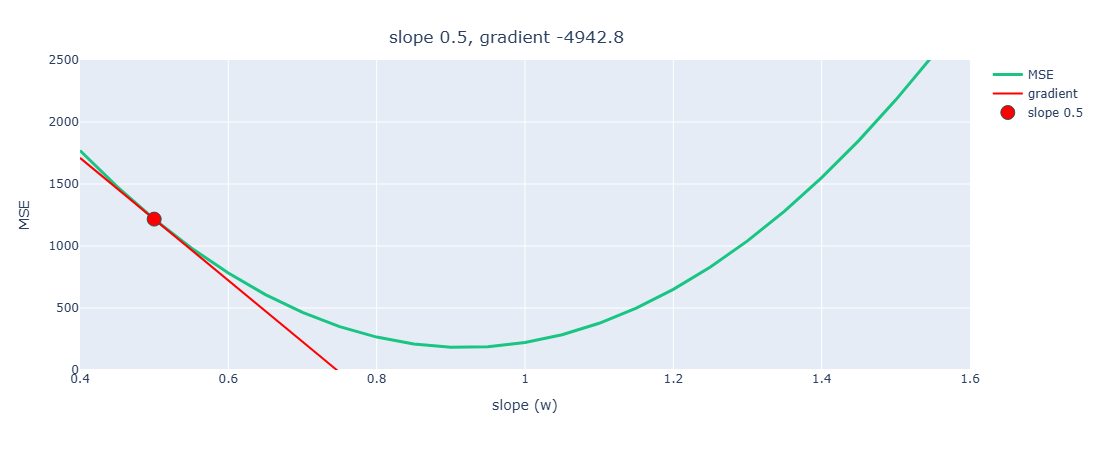

In [56]:
plot_gradient_m(x, y, 0.5, mse["slope"], mse["MSE"], gradient)

The amount we adjust our slope each iteration is controlled by a "learning rate", denoted $\alpha$ (note the minus in the equation below which accounts for flipping the sign of the gradient as discussed above):

$$w_{new} = w - \alpha \times gradient$$

$$w_{new} = w - \alpha \frac{d}{dw}f(w)$$

$\alpha$ is a hyperparameter that can be optimized, typical values range from 0.001 to 0.9. With the math out of the way, we're now ready to use gradient descent to optimize our slope. Gradient descent is an iterative algorithm, meaning that we keep repeating it until we meet some stopping criteria. Typically we stop gradient descent when:
1. the step size is smaller than some pre-defined threshold; or,
2. a certain number of steps is completed.

So the pseudo code for gradient descent boils down to this:

```sh
1. begin with with some arbitrary w
while stopping criteria not met:
    2. calculate mean gradient across all examples
    3. update w based on gradient and learning rate
    4. repeat
```

Let's go ahead and implement that now:

In [79]:
def gradient_descent(x, y, w=0.5, alpha=0.00001, ε=1e-8, max_iterations=10000, print_progress=1000):
    iterations = 0
    dw = float('inf')
    while abs(dw) > ε and iterations <= max_iterations:
        g = gradient(x, y, w)  # calculate current gradient
        dw = alpha * float(g)  # ensure g is converted to a float
        w -= dw
        iterations += 1
        if iterations % print_progress == 0:
            print(f"Iteration {iterations}. w = {w:.4f}, dw = {dw:.4f}")
    print("Terminated!")
    print(f"Iteration {iterations - 1}. w = {w:.4f}.")
    return w

In [81]:
def gradient(x, y, w):
    # Ensure this function returns a single numeric value
    return sum((w * xi - yi) * xi for xi, yi in zip(x, y)) / len(x)

In [83]:
import numpy as np
x = np.array(x, dtype=float)
y = np.array(y, dtype=float)

In [87]:
gradient_descent(x, y, w=0.5, alpha=0.00001)

Terminated!
Iteration 242. w = 0.9186.


/tmp/ipykernel_70279/204475305.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



0.918554866817635

Let's take a look at the journey our slope parameter of our simple linear model went on during its optimization:

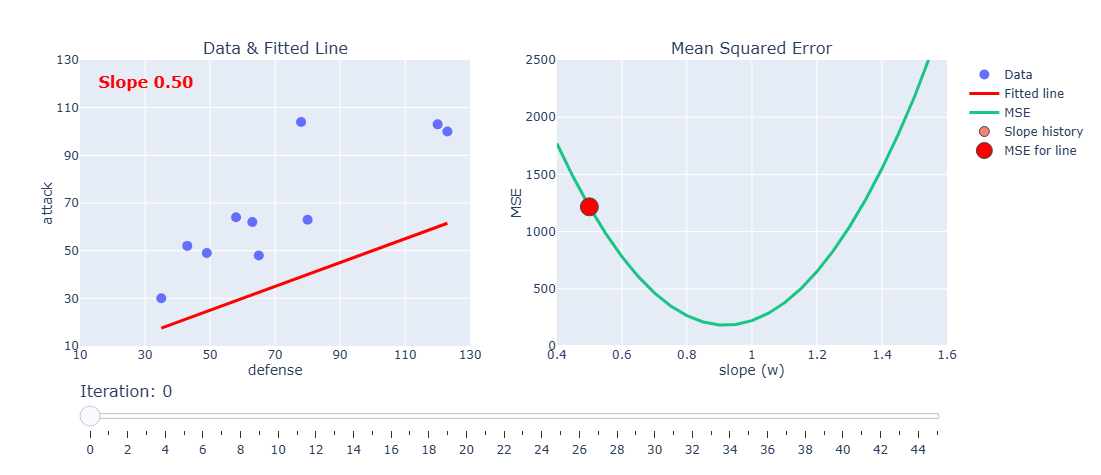

In [85]:
plot_gradient_descent(x, y, w=0.5, alpha=0.00001)

Now let's see what happens if we increase the learning rate:

In [65]:
print(f"Type of x: {type(x)}")
print(f"Shape of x: {x.shape if hasattr(x, 'shape') else 'N/A'}")

Type of x: <class 'pandas.core.series.Series'>
Shape of x: (10,)


In [67]:
if isinstance(x, pd.Series):
    x = x.to_frame()
elif isinstance(x, np.ndarray) and x.ndim == 1:
    x = x.reshape(-1, 1)

In [93]:
gradient_descent(x, y, w=0.5, alpha=0.00005, print_progress=2)

Iteration 2. w = 0.7107, dw = -0.0871
Iteration 4. w = 0.8153, dw = -0.0433
Iteration 6. w = 0.8673, dw = -0.0215
Iteration 8. w = 0.8931, dw = -0.0107
Iteration 10. w = 0.9059, dw = -0.0053
Iteration 12. w = 0.9123, dw = -0.0026
Iteration 14. w = 0.9154, dw = -0.0013
Iteration 16. w = 0.9170, dw = -0.0006
Iteration 18. w = 0.9178, dw = -0.0003
Iteration 20. w = 0.9182, dw = -0.0002
Iteration 22. w = 0.9184, dw = -0.0001
Iteration 24. w = 0.9185, dw = -0.0000
Iteration 26. w = 0.9185, dw = -0.0000
Iteration 28. w = 0.9185, dw = -0.0000
Iteration 30. w = 0.9185, dw = -0.0000
Iteration 32. w = 0.9185, dw = -0.0000
Iteration 34. w = 0.9186, dw = -0.0000
Iteration 36. w = 0.9186, dw = -0.0000
Iteration 38. w = 0.9186, dw = -0.0000
Iteration 40. w = 0.9186, dw = -0.0000
Iteration 42. w = 0.9186, dw = -0.0000
Iteration 44. w = 0.9186, dw = -0.0000
Iteration 46. w = 0.9186, dw = -0.0000
Iteration 48. w = 0.9186, dw = -0.0000
Terminated!
Iteration 47. w = 0.9186.


/tmp/ipykernel_70279/204475305.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



0.9185550036130715

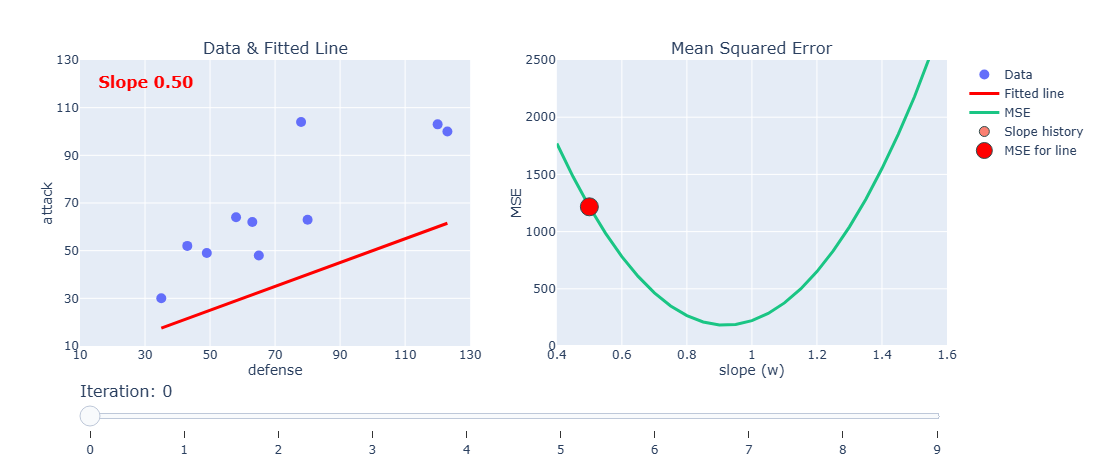

In [91]:
plot_gradient_descent(x, y, w=0.5, alpha=0.00005)

Let's increase a little more:

In [15]:
gradient_descent(x, y, w=0.5, alpha=0.00015)

Iteration 0. w = 0.50.
Iteration 10. w = 0.89.
Iteration 20. w = 0.92.
Iteration 30. w = 0.92.
Terminated!
Iteration 33. w = 0.92.


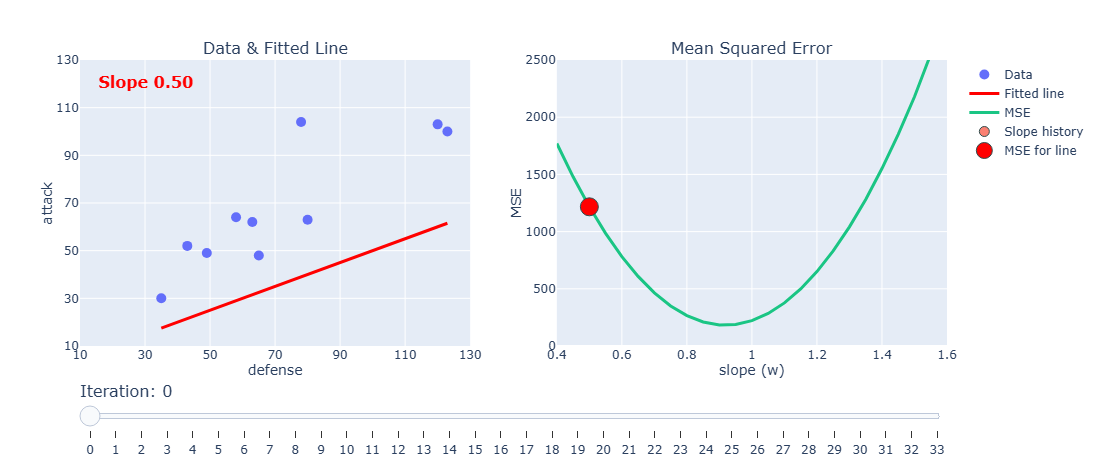

In [16]:
plot_gradient_descent(x, y, w=0.5, alpha=0.00015)

If our learning rate is too high, we'll overshoot and never converge (i.e., we'll diverge)!

In [17]:
gradient_descent(x, y, w=0.5, alpha=0.00018, max_iterations=4, print_progress=1)

Iteration 0. w = 0.50.
Iteration 1. w = 1.39.
Iteration 2. w = 0.39.
Iteration 3. w = 1.52.
Iteration 4. w = 0.25.
Terminated!
Iteration 4. w = 0.25.


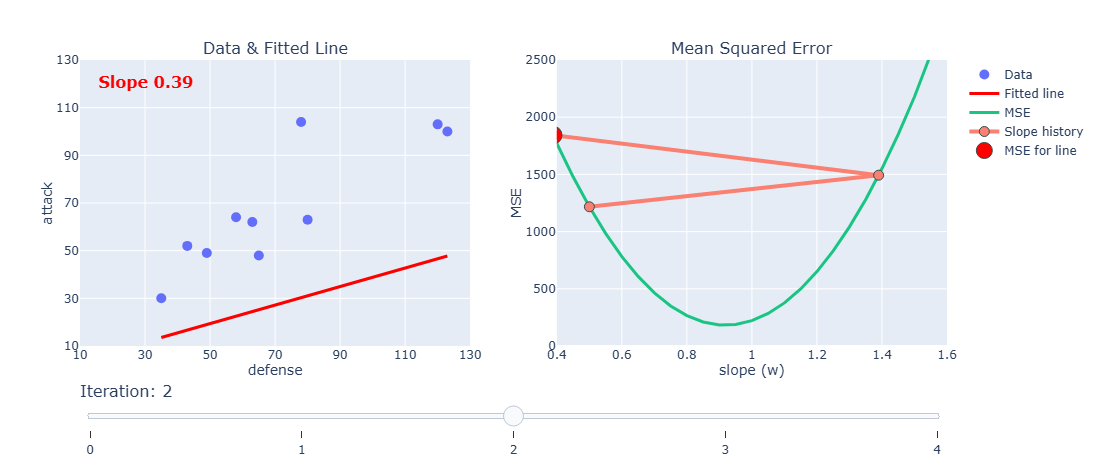

In [18]:
plot_gradient_descent(x, y, w=0.5, alpha=0.00018, max_iterations=4)

Cool, we just implemented gradient descent from scratch! In the next seciton, we'll try optimizing for two parameters, the intercept and slope of a simple linear regression model, simultaneously...

## 5. Gradient Descent With Two Parameters
<hr>

Most of the models you'll be working with will have more than just one parameter to update - neural networks typically have hundreds, thousands, and even millions of parameters! So, let's extend the above workflow to two parameters, the intercept ($w_0$) and the slope ($w_1$). Just to help you get a visual of what's going on, let's take our "manual grid search approach" from earlier and make a plot of it but this time with two parameters:

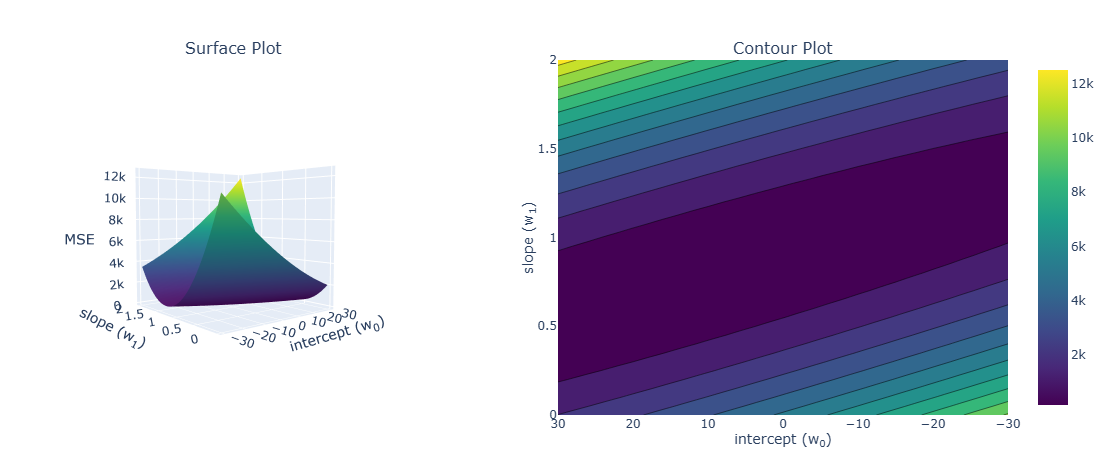

In [19]:
slopes = np.arange(0, 2.05, 0.05)
intercepts = np.arange(-30, 31, 2)
plot_grid_search_2d(x, y, slopes, intercepts)

Above is the surface of MSE for different values of `intercept` ($w_0$) and `slope` ($w_1$). The approach for implementing gradient descent is exactly as before, but we're operating on two parameters now and the gradient of the intercept is a little different to the slope:

$$f(w)=\frac{1}{n}\sum^{n}_{i=1}((w_0 + w_1x)-y_i))^2$$

$$\frac{\partial{}}{\partial{}w_0}f(w)=\frac{1}{n}\sum^{n}_{i=1}2((w_0 + w_1x) - y_i)$$

$$\frac{\partial{}}{\partial{}w_1}f(w)=\frac{1}{n}\sum^{n}_{i=1}2x_i((w_0 + w_1x) - y_i)$$

Let's define a function that returns these two gradients (partial derivatives) of the slope and intercept.

>"Gradient" is technically the vector of all partial derivatives of the loss function with respect to all the model weights. But I use the term fairly loosely to mean either the vector of all partial derivatives, or just a particular partial derivative, which you can infer from the given context.

In [20]:
def gradient(x, y, w):
    grad_w0 = (1/len(x)) * 2 * sum(w[0] + w[1] * x - y)
    grad_w1 = (1/len(x)) * 2 * sum(x * (w[0] + w[1] * x - y))
    return np.array([grad_w0, grad_w1])

gradient(x, y, w=[10, 0.5])

array([  -43.6, -3514.8])

You can already see that the gradient of our slope is orders of magnitude larger than our intercept... we'll look more at this issue shortly. For now let's re-write our gradient descent function from earlier. It's almost exactly the same as before, but now we are updating the slope **and** the intercept each iteration:

In [21]:
def gradient_descent(x, y, w, alpha, ϵ=2e-4, max_iterations=5000, print_progress=10):
    """Gradient descent for optimizing simple linear regression."""
    
    print(f"Iteration 0. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
    iterations = 1  # init iterations
    dw = np.array(2 * ϵ)      # init. dw
    
    while abs(dw.sum()) > ϵ and iterations <= max_iterations:
        g = gradient(x, y, w)  # calculate current gradient
        dw = alpha * g         # change in w
        w -= dw                # adjust w based on gradient * learning rate
        if iterations % print_progress == 0:  # periodically print progress
            print(f"Iteration {iterations}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
        iterations += 1        # increase iteration
        
    print("Terminated!")
    print(f"Iteration {iterations - 1}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")

gradient_descent(x, y, w=[10, 0.5], alpha=0.00001)

Iteration 0. Intercept 10.00. Slope 0.50.
Iteration 10. Intercept 10.00. Slope 0.71.
Iteration 20. Intercept 10.00. Slope 0.77.
Iteration 30. Intercept 10.00. Slope 0.79.
Iteration 40. Intercept 10.00. Slope 0.80.
Terminated!
Iteration 43. Intercept 10.00. Slope 0.80.


Hmm... our algorithm worked but our intercept never changed. Let's take a look at what happened:

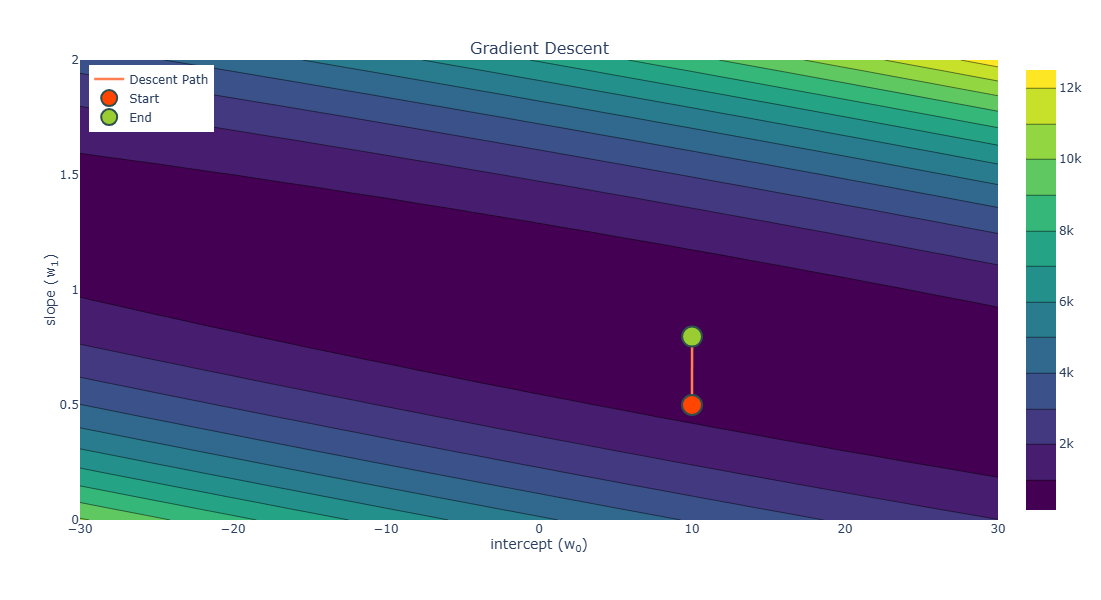

In [22]:
plot_gradient_descent_2d(x, y, w=[10, 0.5], m_range=np.arange(0, 2.05, 0.05), b_range=np.arange(-30, 31, 2), alpha=0.00001)

Only the slope changed in value (we see a vertical line in the plot above, with no change in the intercept parameter). That's because the slope gradient is **wayyyyy** bigger than the intercept gradient. Let's see what the real value of these params are using sklearn's implementation:

In [23]:
m = LinearRegression().fit(np.atleast_2d(x).T, y)
print(f"sklearn inter = {m.intercept_:.2f}")
print(f"sklearn slope = {m.coef_[0]:.2f}")

sklearn inter = 14.02
sklearn slope = 0.75


So we were a bit off in our implementation. We need to get the slope and intercept on the same scale...

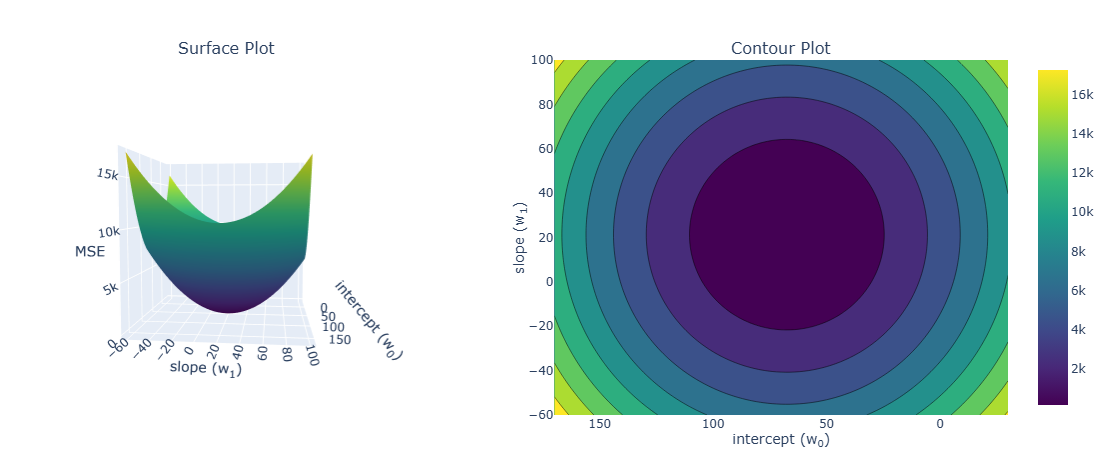

In [25]:
slopes = np.arange(-60, 101, 2)
intercepts = np.arange(-30, 171, 2)
plot_grid_search_2d(x_scaled, y, slopes, intercepts)

Now let's check a random gradient after scaling:

Great, our gradients are on a similar scale now, let's retry gradient descent with our scaled data:

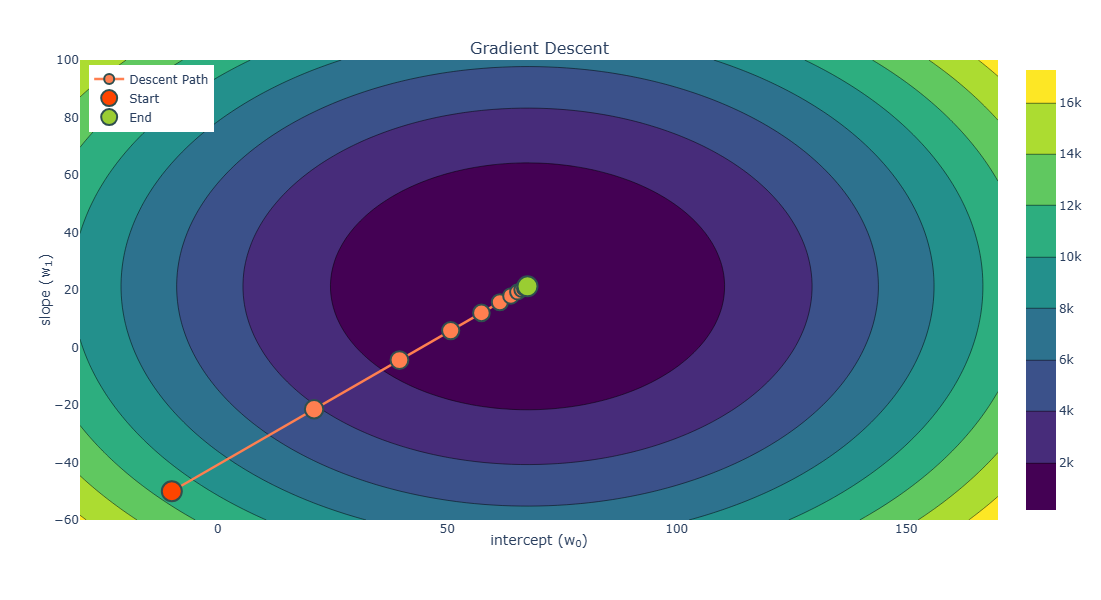

In [29]:
plot_gradient_descent_2d(x_scaled, y, w=[-10, -50], alpha=0.2, m_range=np.arange(-60, 101, 2), b_range=np.arange(-30, 171, 2), markers=True)

Just to drive the point home, note once again that changing the learning rate will affect our optimization (I added some markers on this plot to show you that we're bouncing back-and-forth):

## 6. Other Optimization Algorithms
<hr>

When you saw us using gradients earlier on you might have thought, why not just set the derivative to 0 and solve? You sure could do this! And in general, if a closed form solution exists for your problem, you should typically use it. However:
- Most problems in ML do not have a closed-form solution;
- Even if a closed form solution exists (e.g., linear regression), it can be extremely computationally expensive to compute if your dataset is large (many observations and/or many features).

In these cases, optimization algorithms like gradient descent may be appropriate choices. In actuality you will almost never use vanilla gradient descent in practice because it's actually very slow (but the intuition behind it forms the basis of tons of optimization algorithms so it's a great place to start learning). We'll look at a computationally lighter version of gradient descent next chapter (stochastic gradient descent) and there are also many other algorithms available! You can explore the `scipy` function `minimize` to play around with some of these algorithms: